# Computer Lab: nonnegative matrix factorization

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.sparse
import scipy.sparse.linalg

In [50]:
def build_matrix_from_faces(folder='orl_faces', minidata=False):
    # load images
    # 400 images of size (112, 92)
    M = []
    if minidata is True:
        nb_subjects = 1
    else:
        nb_subjects = 40
    for subject in range(1, nb_subjects + 1
                        ):
        for image in range(1, 11):
            face = plt.imread(folder + '/s' + str(subject)
                              + '/' + str(image) + '.pgm')
            M.append(face.ravel())

    return np.array(M, dtype=float)

def vectorize(W, H):
    return np.concatenate((W.ravel(), H.ravel()))

def unvectorize_M(W_H, M):
    # number of elements in W_H is (n+p)*k where M is of size n x m
    # W has the nk first elements
    # H has the kp last elements
    n, p = M.shape
    k = W_H.shape[0] // (n + p)
    W = W_H[:n * k].reshape((n, k))
    H = W_H[n * k:].reshape((k, p))
    return W, H

Download the database at https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html
Uncompress the file.

In [51]:
# Small data to test the algorithm
M = build_matrix_from_faces(folder='orl_faces', minidata=True)
def unvectorize(W_H): return unvectorize_M(W_H, M)
k = 2

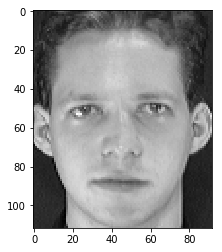

In [52]:
# To see the first face:
plt.imshow(M[0].reshape((112, 92)), cmap='gray'); plt.show()

<div style="border-top:dashed black"/>
<h1><em>Question 2.1</em></h1>

In [53]:
n = len(M)
p = len(M[0])

print("There are", n, "photos with", p, "pixels each.")

There are 10 photos with 10304 pixels each.


<div style="border-top:dashed black"/>
<h1><em>Question 3.1</em></h1>

In 1D, $$n=p=k=1$$ therefore, the objective function is: $$f(w, h) = \frac{1}{2}\left(m - w\cdot h \right)^2$$

We can compute the associated hessian matrix and look if it's positive:


$$H(f)= \begin{bmatrix}
h^2 & -m+2wh \\
-m+2wh & w^2
\end{bmatrix}$$


This matrix isn't positive because its determinant is $h^2w^2 - (m-2wh)^2$ and for $w = h = 0$, this determinant is negative. Therefore, the function isn't convex.

<div style="border-top:dashed black"/>
<h1><em>Question 3.2</em></h1>

Knowing that $<A, B> = Tr(A^T B)$, We can compute the partial differentials by computing $f(W, H+h)$ and isolating the terms linked with $h$ 
Finally, we have:
$$\frac{\partial f}{\partial W} = \frac{1}{np}\left( WH-M \right)H^T$$
and
$$\frac{\partial f}{\partial H} = \frac{1}{np}W^T\left( WH-M \right)$$

<div style="border-top:dashed black"/>
<h1><em>Question 4.1</em></h1>

In [54]:
W0, S, H0 = scipy.sparse.linalg.svds(M, k)
W0 = np.maximum(0, W0 * np.sqrt(S))
H0 = np.maximum(0, (H0.T * np.sqrt(S)).T)

Whith ```scipy.linalg.svds(M, k)``` we get the value for k wich allows to reconstruct an approximation for M with a low complexity. We can initialize them with any positive value.

<div style="border-top:dashed black"/>
<h1><em>Question 4.2</em></h1>

We already know that $$\frac{df}{dW} = \frac{1}{np}\left( WH_0-M \right)H_0^T$$ Therefore, we can diferentiate a second time to obtain:
$$\frac{d^2f}{dW^2} = \frac{1}{np}H_0H_0^T$$
This matrix is positive semi-definite so $g$ is convex.

The gradient of $g$ is :
$$
\nabla g = \frac{1}{np}\left( WH_0-M \right)H_0^T
$$

<div style="border-top:dashed black"/>
<h1><em>Question 4.3</em></h1>

In [55]:
def g(W):
    W = W.reshape((n, k))
    return 1/(2*n*p)*np.linalg.norm(M-np.dot(W, H0))**2

def g_grad(W_):
    W = W_.reshape((n, k))
    gradient = -1/(n*p)*np.dot(M-np.dot(W, H0), H0.T)
    return gradient.ravel()

print(scipy.optimize.check_grad(g, g_grad, W0.ravel()))

2.097820230524603e-05


As ```scipy.optimize.check_grad``` returns the error, we can see that our computation is quite correct because there is a low error.

<div style="border-top:dashed black"/>
<h1><em>Question 4.4</em></h1>

According to the definition,

$$ prox_{\gamma \iota_{\mathbb{R}_{+}}}(x)= \mathop{\arg\min}_{y\in R} \gamma\iota_{\mathbb{R}_{+}}\left(y\right)+\frac{1}{2}||y-x||^{2} $$

$\forall \gamma > 0$, 

$prox_{\gamma \iota_{\mathbb{R}_{+}}}(x) = 0 $ if $  x\leq 0$,

and $prox_{\gamma \iota_{\mathbb{R}_{+}}}(x) = x $ if $x > 0$.

That's quite the definition of the projection on $\mathbb{R}^+$

<div style="border-top:dashed black"/>
<h1><em>Question 4.5</em></h1>

In [56]:
def projected_gradient_method(val_g, grad_g, W0, gamma, N):
    W = W0.ravel()
    g = []
    for i in range(N):
        W = np.maximum(0, W - gamma*grad_g(W))
        g.append(val_g(W))
    return W, val_g(W), g

<div style="border-top:dashed black"/>
<h1><em>Question 4.6</em></h1>

In [57]:
gamma = n*p/np.linalg.norm(np.dot(H0.T, H0))

print("for N = 100, g =", projected_gradient_method(g, g_grad, W0, gamma, 100)[1])

for N = 100, g = 442.2878543960478


<div style="border-top:dashed black"/>
<h1><em>Question 5.1</em></h1>

In [58]:
def armijo_projected_gradient_method(val_g, grad_g, W0, N):
    W = W0.ravel()
    a, gamma, beta, b = 0.5, 0.5,0.5,0.5
    for i in range(N):
        n= 0
        while (val_g(W - b*(a**n)*grad_g(W)) >  val_g(W) + beta*(-b*(a**n))*np.linalg.norm(grad_g(W))**2):
            n+=1
        W = np.maximum(0, W - b*(a**n)*grad_g(W))
        b = 2*b*(a**n)
    return W, val_g(W)

print("for N = 100, g =", armijo_projected_gradient_method(g, g_grad, W0, 100)[1])

for N = 100, g = 442.2300684941508


<div style="border-top:dashed black"/>
<h1><em>Question 6.1 </em></h1>

In [59]:
def obj_function(W_H_vectorized):
    W, H = unvectorize(W_H_vectorized)
    return 1/(2*n*p)*np.linalg.norm(M-np.dot(W, H))**2

def grad_obj_function(W_H_vectorized):
    W, H = unvectorize(W_H_vectorized)
    grad_W = -1/(n*p)*np.dot(M-np.dot(W, H), H.T)
    grad_H = -1/(n*p)*np.dot(W.T, M-np.dot(W, H))
    return vectorize(grad_W, grad_H)

In [73]:
print("for N==1000, objective unction=", armijo_projected_gradient_method(obj_function, grad_obj_function, vectorize(W0, H0), 1000)[1])

for N==1000, objective unction= 358.922911113055


<div style="border-top:dashed black"/>
<h1><em>Question 6.2 </em></h1>

We have $$\frac{1}{np}\|(M-W_{t-1}H_{t-1})\|_{F}^2 \leq \frac{1}{np}\|(M-W_{t}H_{t-1})\|_{F}^2 \leq \frac{1}{np}\|(M-W_{t}H_{t})\|_{F}^2 $$ 

so the objective function decreases and converges as it's positive.

<div style="border-top:dashed black"/>
<h1><em>Question 6.3 </em></h1>

In [71]:
def g_alt(W_vectorized, H_vectorized):
    W = W_vectorized.reshape((n, k))
    H = H_vectorized.reshape((k, p))
    return 1/(2*n*p)*np.linalg.norm(M-np.dot(W, H), ord='fro')**2

def g_grad_alt(W_vectorized, H_vectorized):
    W = W_vectorized.reshape((n, k))
    H = H_vectorized.reshape((k, p))
    grad = -1/(n*p)*np.dot(M-np.dot(W, H), H.T)
    return grad.ravel()

def armijo_projected_gradient_method_W(val_g_alternate, grad_g_alternate, H_vectorized, W0_vectorized, N):
    W = W0_vectorized
    a, gamma, beta = 0.5, 0.5, 0.5
    b = 1
    for i in range(N):
        l = 0
        while (val_g_alternate(W-b*(a**l)*grad_g_alternate(W, H_vectorized), H_vectorized) 
               > val_g_alternate(W, H_vectorized) + beta*(-b*(a**l))*np.linalg.norm(grad_g_alternate(W, H_vectorized))**2):
            l+=1
        W = np.maximum(0, W - b*(a**l)*grad_g_alternate(W, H_vectorized))
        b = 2*b*(a**l)
    return W, g_alt(W, H_vectorized)


def h_alt(W_vectorized, H_vectorized):
    W = W_vectorized.reshape((n, k))
    H = H_vectorized.reshape((k, p))
    return 1/(2*n*p)*np.linalg.norm(M-np.dot(W, H), ord='fro')**2

def h_grad_alt(W_vectorized, H_vectorized):
    W = W_vectorized.reshape((n, k))
    H = H_vectorized.reshape((k, p))
    grad = -1/(n*p)*np.dot(W.T, M-np.dot(W, H))
    return grad.ravel()

def armijo_projected_gradient_method_H(val_h_alternate, grad_h_alternate, H0_vectorized, W_vectorized, N):
    H = H0_vectorized
    a, gamma, beta = 0.5, 0.5, 0.5
    b = 1
    for i in range(N):
        l = 0
        while (val_h_alternate(W_vectorized, H-b*(a**l)*grad_h_alternate(W_vectorized, H)) 
               > val_h_alternate(W_vectorized, H) + beta*(-b*(a**l))*np.linalg.norm(grad_h_alternate(W_vectorized, H))**2):
            l+=1
        H = np.maximum(0, H - b*(a**l)*grad_h_alternate(W_vectorized, H))
        b = 2*b*(a**l)
    return H, h_alt(W_vectorized, H)

def alt_method(N, M):
    W, H = W0.ravel(), H0.ravel()
    for i in range(M):
        W = armijo_projected_gradient_method_W(g_alt, g_grad_alt , H, W, N)[0]
        H = armijo_projected_gradient_method_H(h_alt, h_grad_alt, H, W, N)[0]
    return vectorize(W,H), g_alt(W, H)

In [75]:
print("The new objective function value is ", alt_method(10,100)[1])

The new objective function value is  358.9341707593857


<div style="border-top:dashed black"/>
<h1><em>Question 6.4 </em></h1>

The new objective function value is almost equal to the former one and the new algorithm is much more quick so very efficient.

<div style="border-top:dashed black"/>
<h1><em>Question 6.5 </em></h1>

We can propose for that the algorithm stops if the difference between the value of the objective function before and after the iteration is very short.

In [76]:
# Full data
M = build_matrix_from_faces(folder='orl_faces', minidata=False)
def unvectorize(W_H): return unvectorize_M(W_H, M)
k = 38